In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
data = {
    "Level1": ["Initial Source"] * 12,
    "Level2": ["['GoodCredit'] ✓"] * 6 + ["['GoodCredit'] ✗"] * 6,
    "Level3": ["['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✓",
               "['LoanOverThreshold'] ✗", "['LoanOverThreshold'] ✗", "['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✓",
               "['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✓", "['LoanOverThreshold'] ✗", "['LoanOverThreshold'] ✗"],
    "Level4": ["['SmallAmount'] ✓", "['SmallAmount'] ✓", "['SmallAmount'] ✗", "['SmallAmount'] ✗",
               "['SmallAmount'] ✓", "['SmallAmount'] ✓", "['SmallAmount'] ✓", "['SmallAmount'] ✓",
               "['SmallAmount'] ✗", "['SmallAmount'] ✗", "['SmallAmount'] ✓", "['SmallAmount'] ✓"],
    "Level5": ["['IsNewCredit'] ✓", "['IsNewCredit'] ✗", "['IsNewCredit'] ✓", "['IsNewCredit'] ✗",
               "['IsNewCredit'] ✓", "['IsNewCredit'] ✗", "['IsNewCredit'] ✓", "['IsNewCredit'] ✗",
               "['IsNewCredit'] ✓", "['IsNewCredit'] ✗", "['IsNewCredit'] ✓", "['IsNewCredit'] ✗"],
    "num_cases": [2461, 68, 7288, 267, 4976, 178, 2158, 351, 5845, 1666, 5392, 859],
    "avg_case_duration_seconds": [
        1548907.0, 1171228.0, 1754820.0, 1245295.0, 1472006.0, 1097686.0,
        2294083.0, 1490905.0, 2340604.0, 1548217.0, 2230740.0, 1539130.0
    ]
}

In [3]:
df = pd.DataFrame(data)

fig = px.icicle(
    df,
    path=["Level1", "Level2", "Level3", "Level4", "Level5"],
    values="num_cases",
    color="avg_case_duration_seconds",
    color_continuous_scale="Blues",
    title="Sequential Query Paths – Icicle Chart"
)

fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

In [4]:
df = pd.DataFrame(data)

fig = px.treemap(
    df,
    path=["Level1", "Level2", "Level3", "Level4", "Level5"],
    values="num_cases",
    color="avg_case_duration_seconds",
    color_continuous_scale="Blues",
    title="Treemap of Case Subsets (colored by Avg Duration)"
)

fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
fig.show()

In [5]:
df = pd.DataFrame(data)

path_edges = []
for _, row in df.iterrows():
    full_path = [row["Level1"], row["Level2"], row["Level3"], row["Level4"], row["Level5"]]
    for i in range(len(full_path) - 1):
        edge = (full_path[i], full_path[i + 1])
        path_edges.append((edge, row["avg_case_duration_seconds"]))

edge_dict = {}
for (src, tgt), dur in path_edges:
    key = (src, tgt)
    edge_dict.setdefault(key, []).append(dur)

edges = list(edge_dict.keys())
durations = [sum(durs) / len(durs) for durs in edge_dict.values()]

norm = mcolors.Normalize(vmin=min(durations), vmax=max(durations))
cmap = cm.get_cmap('Blues')
colors = [mcolors.to_hex(cmap(norm(d))) for d in durations]

nodes = sorted({n for e in edges for n in e})
node_indices = {n: i for i, n in enumerate(nodes)}

link_source = [node_indices[src] for src, tgt in edges]
link_target = [node_indices[tgt] for src, tgt in edges]

fig = go.Figure(go.Sankey(
    arrangement="snap",
    orientation="v",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightblue"
    ),
    link=dict(
        source=link_source,
        target=link_target,
        value=durations,
        color=colors,
        hovertemplate='Avg Duration: %{value:.0f} sec<extra></extra>'
    )
))

fig.update_layout(title="Tree Visualization of Sequential Filters (Link Colored by Duration)", font_size=12)
fig.show()

C:\Users\cshek\AppData\Local\Temp\ipykernel_12388\2974217220.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

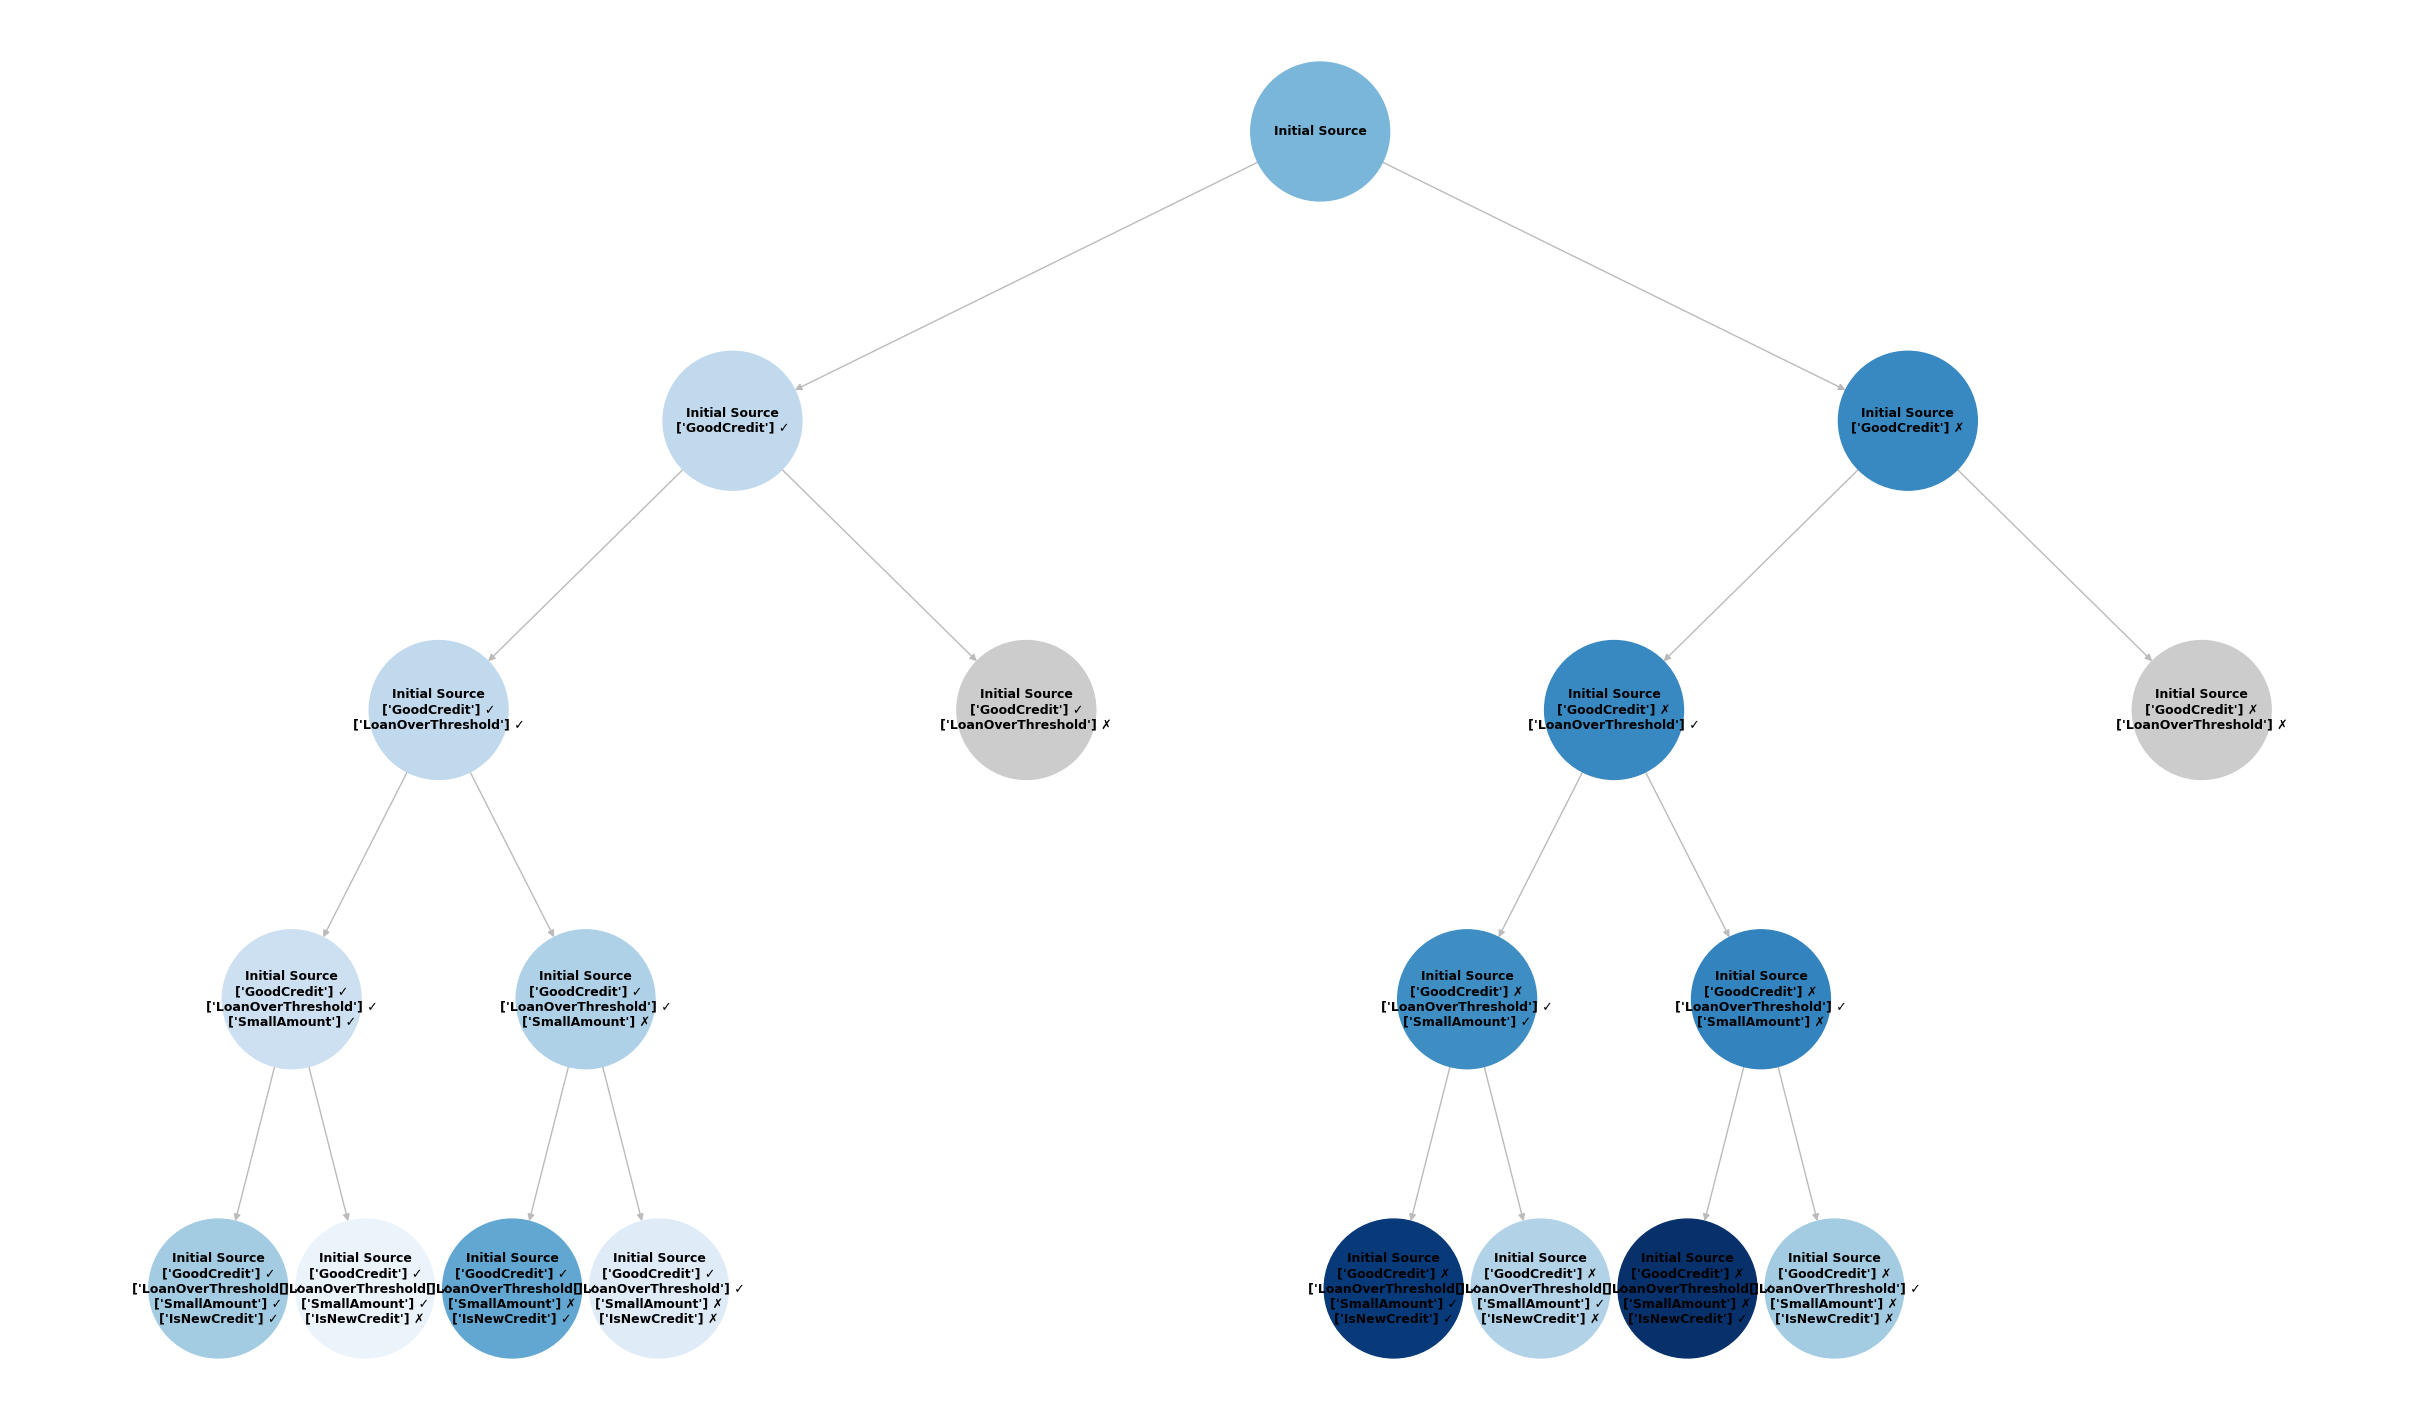

In [6]:
df = pd.DataFrame(data)

G = nx.DiGraph()

def add_binary_splits(df, G, parent='Initial Source', level=2, max_level=5):
    if level > max_level or df.empty:
        return
    col = f'Level{level}'
    values = df[col].unique()
    if len(values) != 2:
        return
    val_1, val_2 = values
    node_1 = f"{parent}\n{val_1}"
    node_2 = f"{parent}\n{val_2}"
    G.add_edge(parent, node_1)
    G.add_edge(parent, node_2)
    add_binary_splits(df[df[col] == val_1], G, node_1, level + 1, max_level)
    add_binary_splits(df[df[col] == val_2], G, node_2, level + 1, max_level)

add_binary_splits(df, G)

node_durations = {}

for i, row in df.iterrows():
    path = ["Initial Source", row["Level2"], row["Level3"], row["Level4"], row["Level5"]]
    current = path[0]
    for level in path[1:]:
        next_node = f"{current}\n{level}"
        current = next_node
    node_durations[current] = row["avg_case_duration_seconds"]

def assign_internal_durations(G, node):
    if node in node_durations:
        return node_durations[node]
    children = list(G.successors(node))
    if not children:
        return None
    values = [assign_internal_durations(G, child) for child in children if assign_internal_durations(G, child) is not None]
    if values:
        avg = sum(values) / len(values)
        node_durations[node] = avg
        return avg
    return None

assign_internal_durations(G, "Initial Source")

durations = list(node_durations.values())
norm = Normalize(vmin=min(durations), vmax=max(durations))
colors = {node: cm.Blues(norm(node_durations[node])) for node in G.nodes if node in node_durations}

def improved_hierarchy_pos(G, root, width=2., vert_gap=0.5, vert_loc=0, xcenter=0.5):
    pos = {root: (xcenter, vert_loc)}
    children = list(G.successors(root))
    if not children:
        return pos
    dx = width / len(children)
    nextx = xcenter - width / 2 + dx / 2
    for child in children:
        pos.update(improved_hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                          vert_loc=vert_loc - vert_gap, xcenter=nextx))
        nextx += dx
    return pos

plt.figure(figsize=(24, 14))
pos = improved_hierarchy_pos(G, "Initial Source")
node_colors = [colors.get(node, (0.8, 0.8, 0.8)) for node in G.nodes]

nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=10000,
        font_size=9, font_weight="bold", edge_color="#BBBBBB", linewidths=1)
sm = plt.cm.ScalarMappable(cmap=cm.Blues, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Avg Case Duration (seconds)")
plt.title("Binary Filter Tree with Avg Duration as Node Color", fontsize=16)
plt.axis("off")
plt.show()